### MasaCtrl: Tuning-free Mutual Self-Attention Control for Consistent Image Synthesis and Editing

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
import numpy as np

from tqdm import tqdm
from einops import rearrange, repeat
from omegaconf import OmegaConf

from diffusers import DDIMScheduler, StableDiffusionPipeline
from diffusers.utils.torch_utils import randn_tensor
from masactrl.diffuser_utils import MasaCtrlPipeline
from masactrl.masactrl_utils import AttentionBase
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
from masactrl.inversion import DirectInversion
import cv2
from torchvision.utils import save_image
from torchvision.io import read_image
from pytorch_lightning import seed_everything
from matplotlib import pyplot as plt
torch.cuda.set_device(0)  # set the GPU device

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Model Construction

In [2]:
# Note that you may add your Hugging Face token to get access to the models
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model_path = "xyn-ai/anything-v4.0"
model_path = "/hy-tmp/SD2-1-base"
# model_path = "runwayml/stable-diffusion-v1-5"
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    scheduler=scheduler,
    custom_pipeline="/hy-tmp/MyREMOVAL/pipeline_mine_DI.py",
    torch_dtype=torch.float32
)
pipe = pipe.to(device)

Loading pipeline components...:  17%|█▋        | 1/6 [00:00<00:00,  7.18it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]
/root/.cache/huggingface/modules/diffusers_modules/local/pipeline_mine_DI.py:203: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be 

In [3]:
from masactrl.masactrl import MutualSelfAttentionControl,MutualSelfAttentionControlMask_An,MutualSelfAttentionControlMask_An_aug,MutualSelfAttentionControlMask_An_xrep
from torchvision.io import read_image
import PIL.Image as Image

def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image

def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (512, 512))
    image = image.to(torch.float32).to(device)
    return image

def load_mask(mask_path, device):
    mask = read_image(mask_path,mode=ImageReadMode.GRAY)
    mask = mask.unsqueeze_(0).float() / 255.  # 0 or 1
    mask = F.interpolate(mask, (512, 512))
    mask = mask.to(torch.float32).to(device)
    return mask

seed = 123
seed_everything(seed)
sample = "44"
out_dir = f"./workdir/{sample}/"
os.makedirs(out_dir, exist_ok=True)
sample_count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{sample_count}")
os.makedirs(out_dir, exist_ok=True)
# source image
SOURCE_IMAGE_PATH = f"/hy-tmp/MyREMOVAL/examples/img/{sample}.png"
MASK_PATH = f"/hy-tmp/MyREMOVAL/examples/mask/{sample}_mask.png"
#SOURCE_IMAGE_PATH = "/home/user01/AnonymousEditing/examples/img/an.png"
#MASK_PATH = "/home/user01/AnonymousEditing/examples/mask/an_mask.png"
source_image = load_image(SOURCE_IMAGE_PATH, device)
mask = load_mask(MASK_PATH, device)

image_gt = load_512(SOURCE_IMAGE_PATH)

Seed set to 123


In [4]:
source_prompt = ""
target_prompt = ""
prompts = [source_prompt, target_prompt]
num_ddim_steps = 50
null_inversion = DirectInversion(model=pipe,
                                num_ddim_steps=num_ddim_steps)
pipe.scheduler.set_timesteps(num_ddim_steps)

_, image_enc_latent, x_stars, noise_loss_list = null_inversion.invert(
    image_gt=image_gt, prompt=prompts, guidance_scale=1)

In [5]:
start_code  = x_stars[-1].expand(len(prompts), -1, -1, -1)
x0 = x_stars[0]
# inference the synthesized image with MasaCtrl
START_STEP = 0
END_STEP = 50
LAYER = 7 #0~5down,6mid,7~15up
END_LAYER = 16

# hijack the attention module
editor = MutualSelfAttentionControlMask_An(START_STEP, END_STEP, LAYER, END_LAYER, mask=mask)
regiter_attention_editor_diffusers(pipe, editor)

#image, pred_x0_list_denoise, latents_list_denoise = pipe(
image = pipe(
    prompts,
    width=512,
    height=512,
    num_inference_steps=50,
    guidance_scale=1.0,
    latents=start_code,
    x0_latents=x0,
    #x0_latents=latents_list[0],
    record_list = list(reversed(x_stars)),
    #noise_loss_list = list(reversed(noise_loss_list)),
    mask = mask,
    return_intermediates = False,
)

AN at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
AN at U-Net layers:  [7, 8, 9, 10, 11, 12, 13, 14, 15]
Using mask-guided AN


 20%|██        | 10/50 [00:01<00:06,  6.19it/s]

100%|██████████| 50/50 [00:08<00:00,  6.15it/s]


Syntheiszed images are saved in ./workdir/44/sample_1


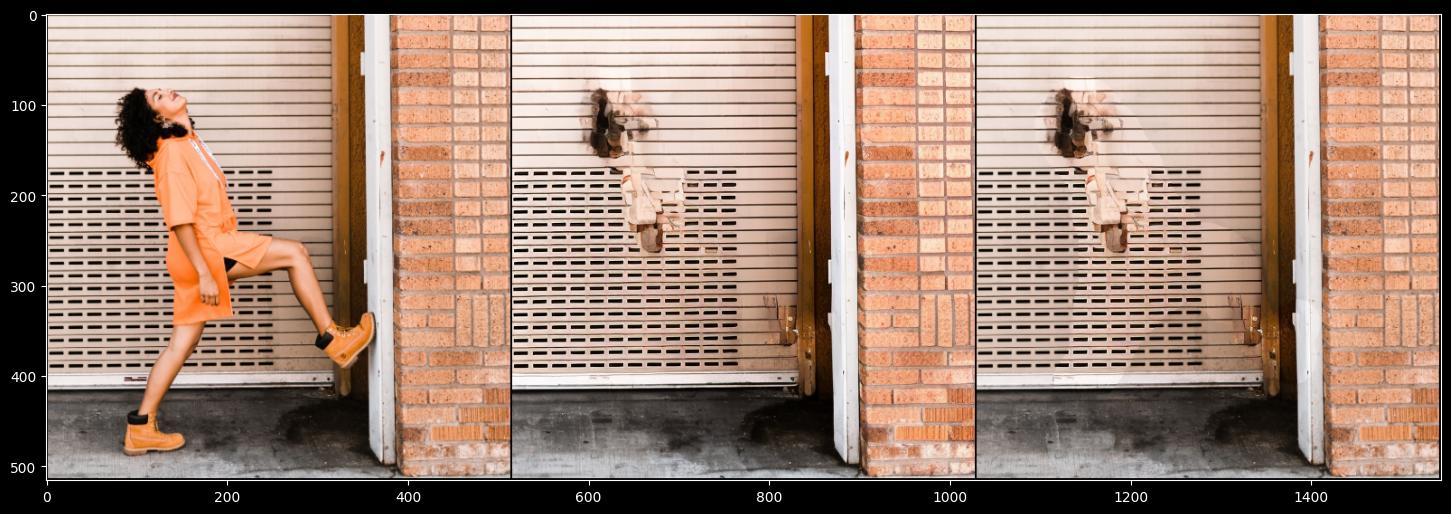

In [6]:
out_tile = mask * image[-1:] + (1 - mask) * (source_image* 0.5 + 0.5)
out_image = torch.concat([source_image* 0.5 + 0.5,
                         image[-1:],
                         out_tile],
                         dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"anonymous_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"anonymous_tile_step{END_STEP}_layer{LAYER}.png"))
print("Syntheiszed images are saved in", out_dir)
img_ori = cv2.imread(os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 24))
plt.imshow(img_ori)

In [7]:
""" out_image = torch.cat([source_image * 0.5 + 0.5,
                       image[0:1],
                       image[-1:]], dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"reconstructed_source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))

print("Syntheiszed images are saved in", out_dir)

img_ori = cv2.imread(os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_ori) """



' out_image = torch.cat([source_image * 0.5 + 0.5,\n                       image[0:1],\n                       image[-1:]], dim=0)\nsave_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))\nsave_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))\nsave_image(out_image[1], os.path.join(out_dir, f"reconstructed_source_step{END_STEP}_layer{LAYER}.png"))\nsave_image(out_image[2], os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))\n\nprint("Syntheiszed images are saved in", out_dir)\n\nimg_ori = cv2.imread(os.path.join(out_dir, f"masactrl_step{END_STEP}_layer{LAYER}.png"))\nimg_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)\nplt.figure(figsize=(6, 6))\nplt.imshow(img_ori) '

In [8]:
""" # 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(pred_x0_list_denoise[30:40][i])
    ax.axis('off')  # 隐藏坐标轴

plt.show() """

" # 假设 images 是你的 numpy 数组，其形状为 (10, 512, 512, 3)\nfig, axs = plt.subplots(2, 5, figsize=(15, 6))\n\nfor i, ax in enumerate(axs.flatten()):\n    ax.imshow(pred_x0_list_denoise[30:40][i])\n    ax.axis('off')  # 隐藏坐标轴\n\nplt.show() "